In [1]:
#############################
##### Import Libraries ######
#############################

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
import random
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label

C:\Users\satrivedi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\satrivedi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


The training data for classifier consists of 8792  car images and 8968  non-car images
of size:  (64, 64, 3)  and data type of each image is: float32


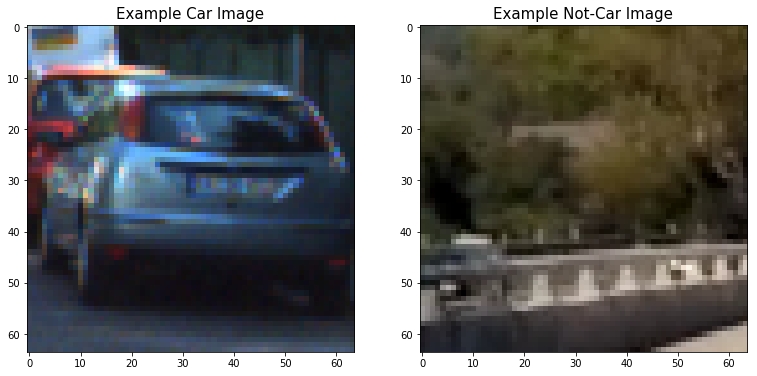

In [2]:
#####################################
###### Import Labelled Dataset ######
#####################################

def plot(img1, img2, label1, label2, fname):
    f, (p1, p2) = plt.subplots(1,2, figsize=(10,6))
    p1.imshow(img1)
    p1.set_title(label1, fontsize=15)
    p2.imshow(img2, cmap='gray')
    p2.set_title(label2, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
#     f.savefig('output_images/'+fname+'.png') #save last pic for report

# Fetching all the car and non_car image list provided by Udacity
cars_list = []
notcars_list = []

car_image_dirs = ['./training_data/vehicles/KITTI_extracted/', 
                  './training_data/vehicles/GTI_Right/image',
                  './training_data/vehicles/GTI_Left/image', 
                  './training_data/vehicles/GTI_MiddleClose/image', 
                  './training_data/vehicles/GTI_Far/image']

non_car_image_dirs = ['./training_data/non-vehicles/GTI/image',
                      './training_data/non-vehicles/Extras/extra']

for car_image_dir in car_image_dirs:    
    for car_fname in glob.glob(car_image_dir + '*.png'):
        cars_list.append(car_fname)
        
for non_car_image_dir in non_car_image_dirs:
    for non_car_fname in glob.glob(non_car_image_dir + '*.png'):
        notcars_list.append(non_car_fname)

# print(len(cars_list))
# print(len(notcars_list))

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = np.shape(test_img)
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars_list, notcars_list)

print('The training data for classifier consists of', 
      data_info["n_cars"], ' car images and', 
      data_info["n_notcars"], ' non-car images')
print('of size: ',data_info["image_shape"], ' and data type of each image is:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_list))
notcar_ind = np.random.randint(0, len(notcars_list))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_list[car_ind])
notcar_image = mpimg.imread(notcars_list[notcar_ind])


# Plot the examples
plot(car_image, notcar_image, 'Example Car Image', 'Example Not-Car Image','Example_of_Training_Set')

In [3]:
##########################################
###### Feature Extraction Functions ######
##########################################

# Finding the Color Histogram
def convert_color(img, conv='YCrCb'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'GRAY':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)   

def color_hist(img, hist_bins=32, hist_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=hist_bins, range=hist_range)
    ch2_hist = np.histogram(img[:,:,1], bins=hist_bins, range=hist_range)
    ch3_hist = np.histogram(img[:,:,2], bins=hist_bins, range=hist_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, spatial_size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, spatial_size).ravel() 
    # Return the feature vector
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_features(img_list, orient, pix_per_cell, cell_per_block,
                     color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hog_channel=0, vis=True, feature_vec=True, 
                     spatial_feat = True, hist_feat = True, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_list:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, conv=color_space)
        else: feature_image = np.copy(image)
        
        # Compute Spatial Bins in lower resolution  
        if spatial_feat == True:
            spatial_features = bin_spatial(image, spatial_size=spatial_size)
#             print(np.shape(spatial_features))
            # Append spatial features to each file feature
            file_features.append(spatial_features)
        #Find the color Histogram
        if hist_feat == True:
            hist_features = color_hist(image, hist_bins=32)
#             print(np.shape(hist_features))
                                                                                        
        # Append color histogram features to each file feature
        file_features.append(hist_features)

        # Call get_hog_features()
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Concatenate addon_features list and hog_features to append to the feature vector
        # Append HOG features to each file feature
#         print(np.shape(hog_features))
        file_features.append(hog_features)
        #Append all the features to the main feature vector
        features.append(np.concatenate(file_features))    

    return features 

C:\Users\satrivedi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


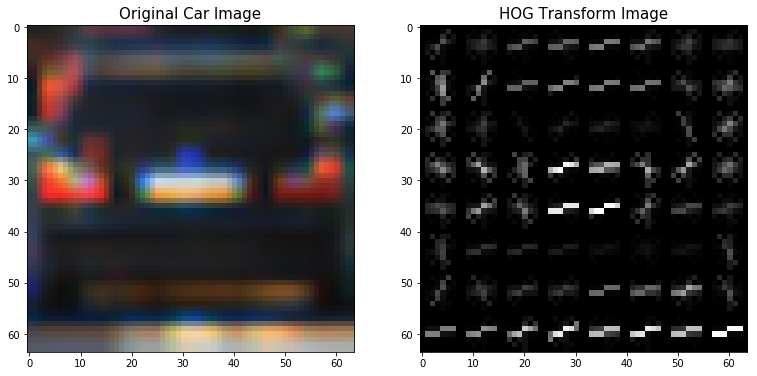

96 s to perform feature extraction
Car Features per Image:  9048
Shape of Car Feature Vector:  (8792, 9048)
Non Car Features per Image:  9048
Shape of Non Car Feature Vector :  (8968, 9048)


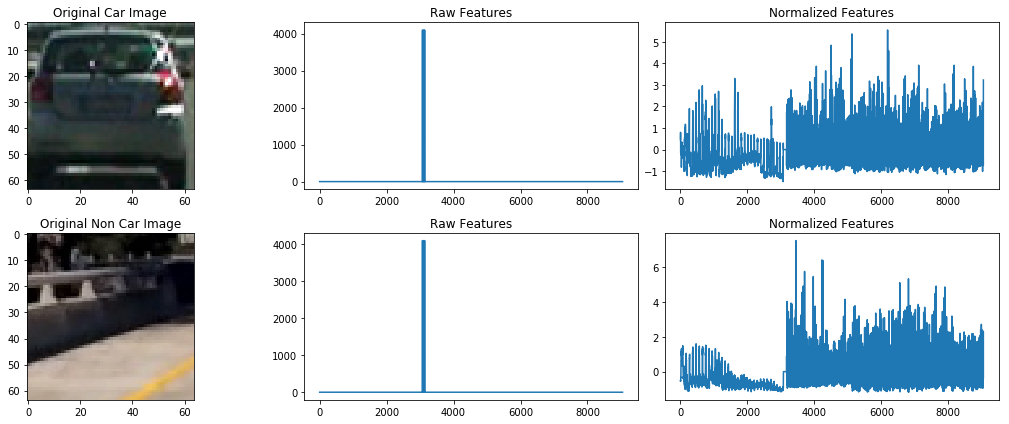

In [4]:
########################################
###### Feature Extraction Process ######
########################################

### Feature Extraction Parameters ###

orient = 10             # The number of orientation bins that the gradient information will be split up (select btw 6-12)
pix_per_cell = 8       # The cell size over which each gradient histogram is computed 
cell_per_block = 2      # Specifies the local area over which the histogram counts in a given cell will be normalized
cspace ='YCrCb'           # Select the color space - RGB, HSV, LUV, HLS, YUV, YCrCb 
spatial_size = (32, 32) # Size of image to be scaled down to for Spatial Binning of Colors
hist_bins = 32          # Define number of bins for color histogram
hog_channel = 'ALL'         # extract HOG features from the first, second, third, or all color channels - 0,1,2,'ALL'
vis = False             # Flag to enable HOG Transform visualization
feature_vec=True        # Flag to output HOG feature vectors
spatial_feat = True     # Flag to enable Spatial feature extraction
col_hist_feat = True    # Flag to enable color histogram feature extraction
hog_feat = True         # Flag to enable HOG feature extraction

### Generate a random index to look at a car image ###

ind = np.random.randint(0, len(cars_list))
# Read in the image
example_image = mpimg.imread(cars_list[ind])
gray = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
HOG_features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
# Plot the examples
plot(example_image, hog_image, 'Original Car Image', 'HOG Transform Image','HOG_Transform_of_Example')

### Extract all the features for car and non_car images ###
t=time.time()
car_features = extract_features(cars_list, orient, pix_per_cell, cell_per_block,
                                color_space = cspace, spatial_size = spatial_size,
                                hist_bins = hist_bins, hog_channel = hog_channel, 
                                vis = vis, feature_vec = feature_vec, 
                                spatial_feat = spatial_feat, hist_feat = col_hist_feat, hog_feat = hog_feat)

notcar_features = extract_features(notcars_list, orient, pix_per_cell, cell_per_block,
                                color_space = cspace, spatial_size = spatial_size,
                                hist_bins = hist_bins, hog_channel = hog_channel, 
                                vis = vis, feature_vec = feature_vec, 
                                spatial_feat = spatial_feat, hist_feat = col_hist_feat, hog_feat = hog_feat)
t2=time.time()

print(int(t2-t), "s to perform feature extraction")
print("Car Features per Image: ",np.shape(car_features)[1])
print("Shape of Car Feature Vector: ",np.shape(car_features))

print("Non Car Features per Image: ",len(notcar_features[1]))
print("Shape of Non Car Feature Vector : ",np.shape(notcar_features))



if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars_list))
    notcar_ind = np.random.randint(0, len(notcars_list))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(15,6))
    plt.subplot(231)
    plt.imshow(mpimg.imread(cars_list[car_ind]))
    plt.title('Original Car Image')
    plt.subplot(232)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(233)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    plt.subplot(234)
    plt.imshow(mpimg.imread(notcars_list[notcar_ind]))
    plt.title('Original Non Car Image')
    plt.subplot(235)
    plt.plot(X[notcar_ind])
    plt.title('Raw Features')
    plt.subplot(236)
    plt.plot(scaled_X[notcar_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')
    
# fig.savefig('output_images/Normalization_of_Features.png') #save last pic for report

In [5]:
##############################
###### Build Classifier ######
##############################

# Prepare labels
Y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split the data into random training and test examples
rand_state = np.random.randint(0, 100)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=rand_state)
print(np.shape(X_train))
print(np.shape(Y_train))

t = time.time()
# parameters = {'kernel':('linear'), 'C':[1, 5, 10]}
clf = LinearSVC()
# clf = GridSearchCV(svr, parameters)
# clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
t2 = time.time()
print(int(t2-t), ' s to train the SVM model')

print('Saving the Model...')
filename = 'Trained_SVM_Modelv2.sav'
pickle.dump(clf, open(filename, 'wb'))

 
# load the model from disk
# print('Loading the Model...')
# clf = pickle.load(open(filename, 'rb'))

n_predict = random.sample(range(0, len(X_test)), 10)

t = time.time()
print('Test Accuracy of SVC = ', (round(clf.score(X_test, Y_test)*100, 4)), '%')
print('Prediction for 10 random test images: ', clf.predict(X_test[n_predict]))
print('Actual Prediction for 10 test images: ', Y_test[n_predict])
t2 = time.time()
print(int(t2-t), ' s to predict 10 random images')

(14208, 9048)
(14208,)
7  s to train the SVM model
Saving the Model...
Test Accuracy of SVC =  98.9302 %
Prediction for 10 random test images:  [1. 0. 1. 0. 1. 1. 0. 1. 1. 0.]
Actual Prediction for 10 test images:  [1. 0. 1. 0. 1. 1. 0. 1. 1. 0.]
0  s to predict 10 random images


In [6]:
######################################
###### Finding Cars in an Image ######
######################################

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    pix_per_step_X = np.int(xy_window[0]*(1-xy_overlap[0]))
    pix_per_step_Y = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/pix_per_step_X) 
    ny_windows = np.int((yspan-ny_buffer)/pix_per_step_Y)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
        # Calculate each window position
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*pix_per_step_X + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*pix_per_step_Y + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, conv=color_space)
    else: feature_image = np.copy(img)      
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, spatial_size=spatial_size)
        img_features.append(spatial_features)
#         print(spatial_features.shape)
    #4) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, hist_bins=hist_bins)
        img_features.append(hist_features)
#         print(np.shape(hist_features))
    #5) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True)) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        hog_features = np.hstack(hog_features)
    #     print(np.shape(hog_features))
        img_features.append(hog_features)

    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, spatial_size=spatial_size)
            hist_features = color_hist(subimg, hist_bins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, rectangles
   
def add_heat(heatmap, bboxes):
    # Iterate through list of bboxes
    for bbox_list in bboxes:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        cv2.putText(img, "CAR!", (bbox[0][0], bbox[0][1]-10) , cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    # Return the image
    return img    

C:\Users\satrivedi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


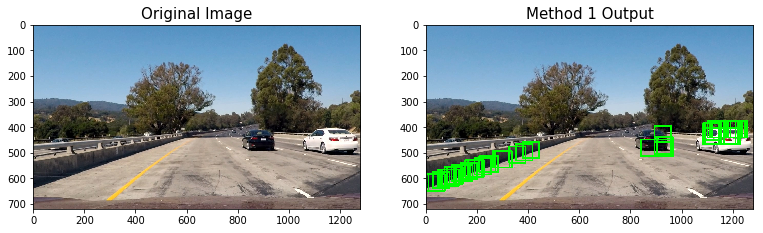

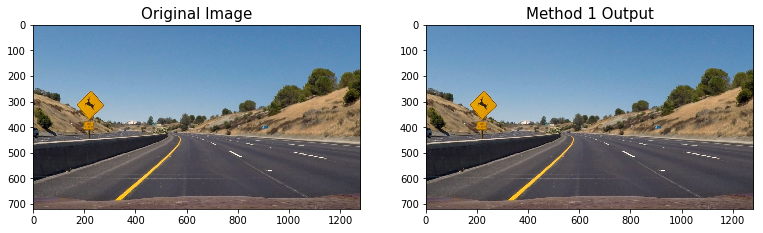

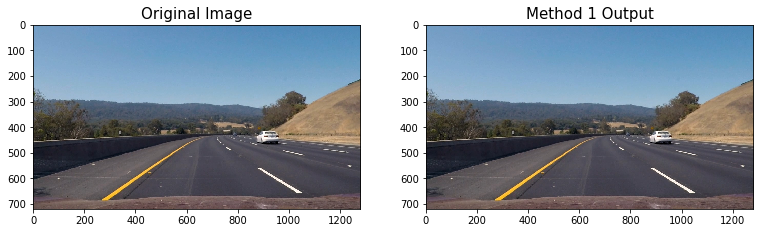

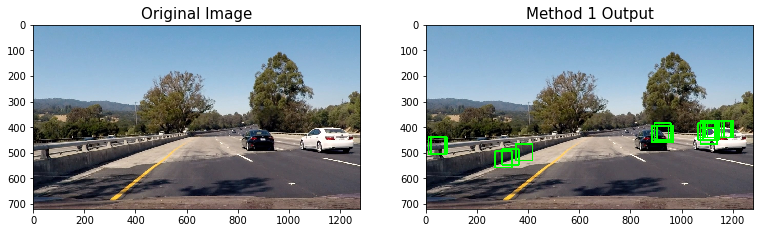

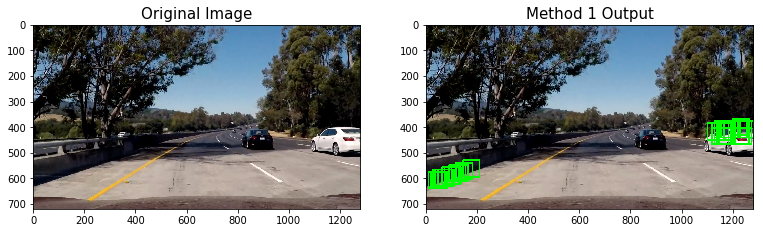

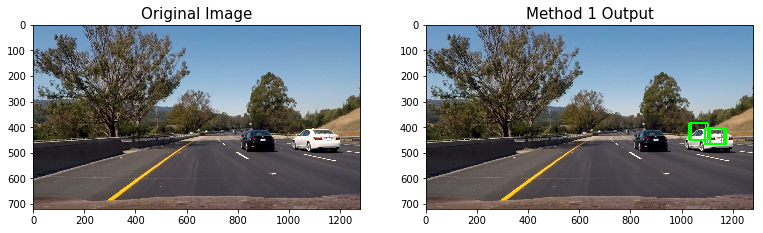

In [7]:
### Method 1 - Sliding Window ###
for image_list in glob.glob('./test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(image_list), cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[350, 700], 
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85))


    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    
#     plot(test_image, window_img, 'Original Image', 'Sliding Window Image','Sliding_Window_Image')

    hot_windows = (search_windows(draw_image, windows, clf, X_scaler, color_space=cspace, 
                                  spatial_size=spatial_size, hist_bins=hist_bins, 
                                  orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, 
                                  hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                  hist_feat=col_hist_feat, hog_feat=hog_feat))

    detected_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                       
    plot(image, detected_img, 'Original Image', 'Method 1 Output','Method_1_Output')

C:\Users\satrivedi\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


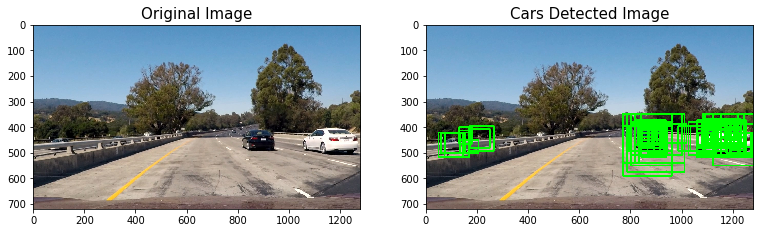

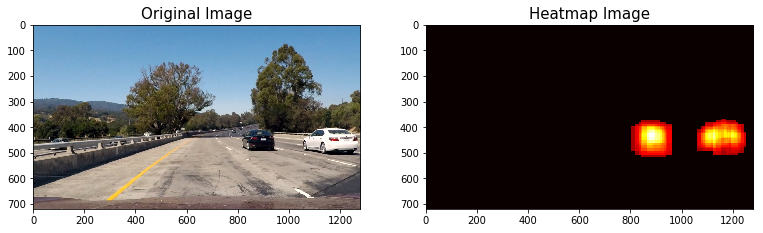

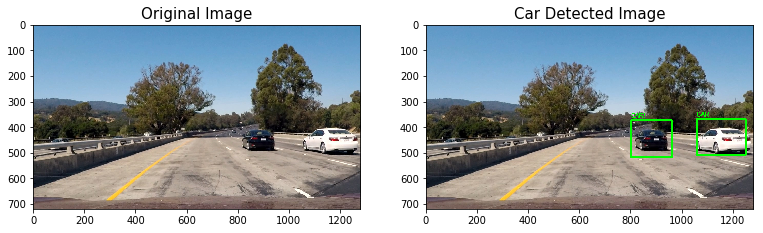

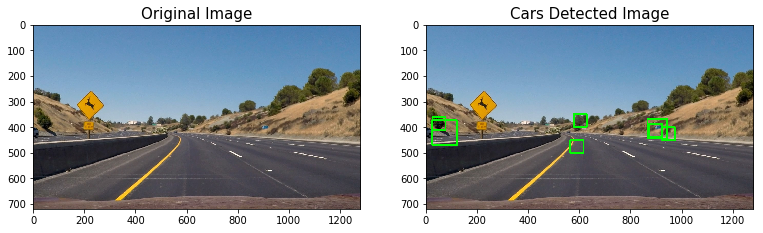

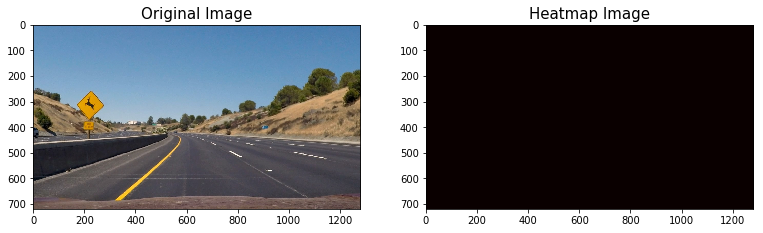

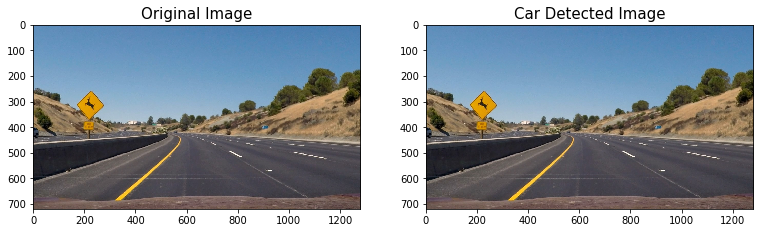

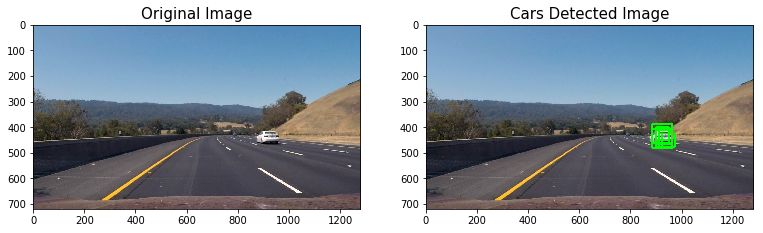

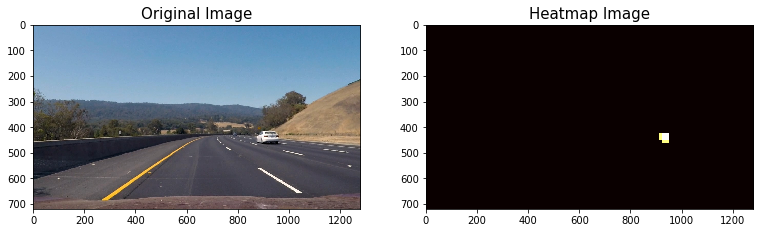

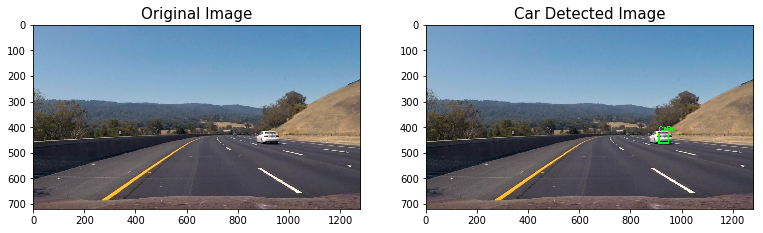

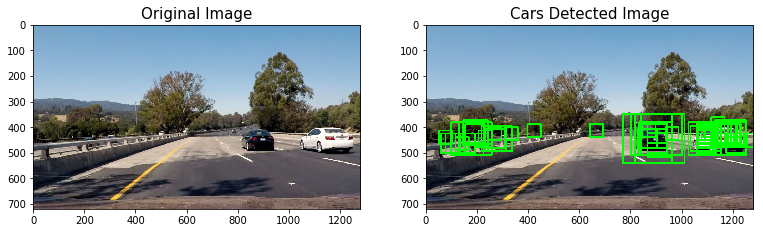

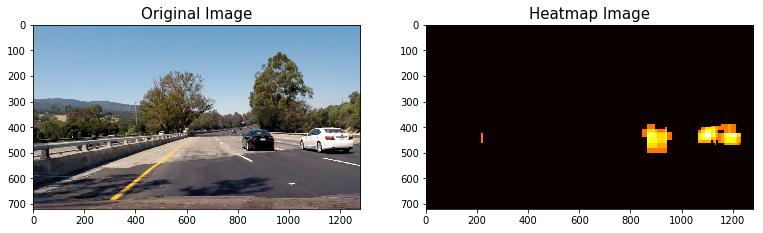

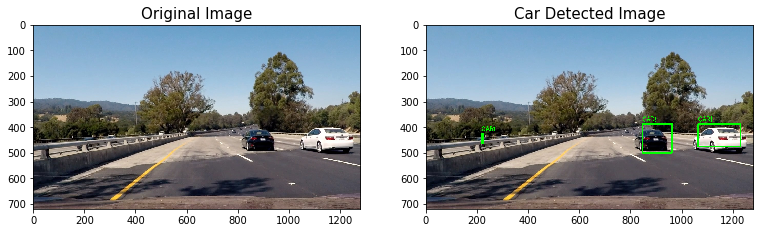

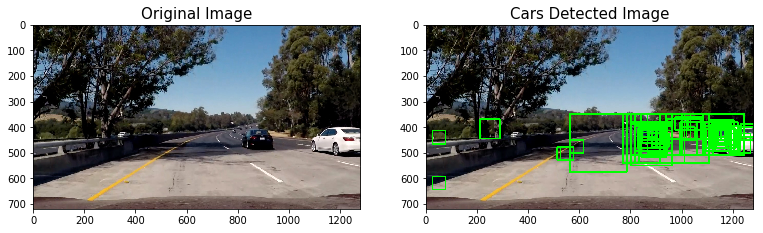

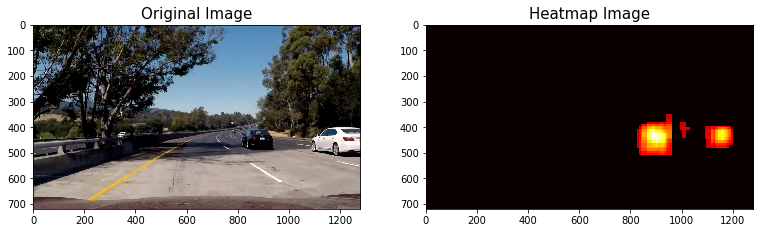

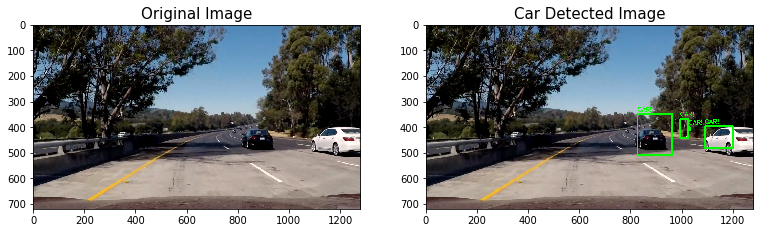

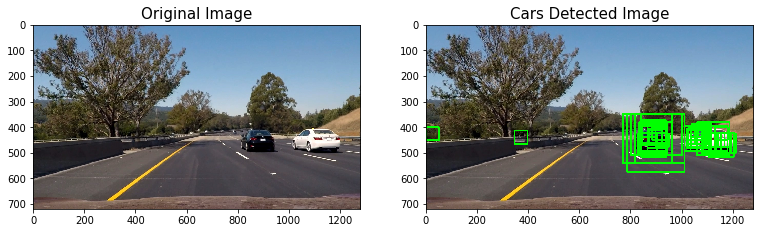

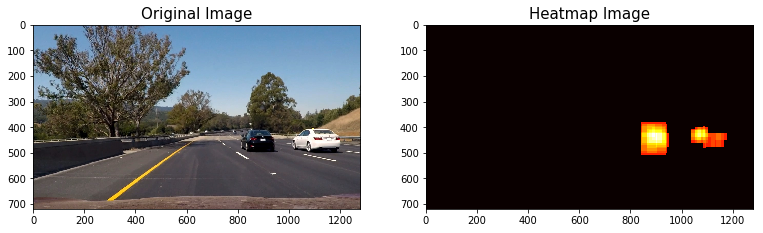

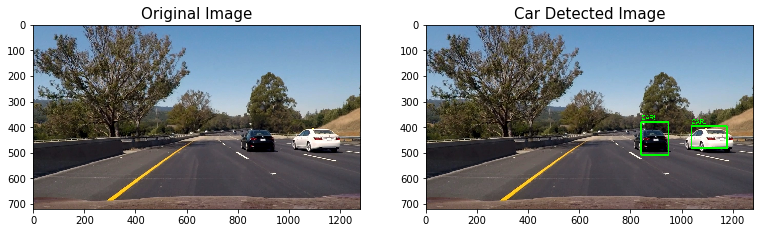

In [8]:
### Method 2 - Variable Size Windows ###
for image_list in glob.glob('./test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(image_list), cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    
    ystart = 350
    ystop = 700
    bboxes = []
    scale = [0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 3.5]
    for i in range(len(scale)):
        out_img, bbox_list = find_cars(draw_image, ystart, ystop, scale[i], clf, X_scaler, orient=orient,
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size=spatial_size, hist_bins=hist_bins)
        bboxes.append(bbox_list)
    rectangles = [item for sublist in bboxes for item in sublist]
    window_img = draw_boxes(draw_image, rectangles, color=(0, 255, 0), thick=6)
    plot(image, window_img, 'Original Image', 'Cars Detected Image','Car_Detection')
    
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 6)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    fig, (p1, p2) = plt.subplots(1,2, figsize=(10,6))
    p1.imshow(draw_image)
    p1.set_title('Original Image', fontsize=15)
    p2.imshow(heatmap, cmap='hot')
    p2.set_title('Heatmap Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    # fig.savefig('output_images/heatmap.png')


    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(draw_image), labels)

    plot(draw_image, final_img, 'Original Image', 'Car Detected Image','Final_Detection_Image')

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def VD_Pipeline(img):
    ystart = 350
    ystop = 700
    bboxes = []

    ystart = 350
    ystop = 700
    bboxes = []
    scale = [0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 3.5]
    for i in range(len(scale)):
        out_img, bbox_list = find_cars(img, ystart, ystop, scale[i], clf, X_scaler, orient=orient,
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size=spatial_size, hist_bins=hist_bins)
        bboxes.append(bbox_list)
        if np.shape(bbox_list)[0] != 0:
            bboxes.append(bbox_list)
        else:
            pass

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,10)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return final_img

In [ ]:
white_output = './project_video_output2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(VD_Pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output2.mp4
[MoviePy] Writing video ./project_video_output2.mp4


  4%|█▌                                    | 53/1261 [05:12<2:10:29,  6.48s/it]